# Purpose

This notebook explores the statistical properties of SPY returns and volatility, and motivates the modelling choices used in subsequent forecasting exercises.

The goal is to determine whether returns and volatility can be modelled separately for forecasting and risk estimation purposes.

# Load processed data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

In [96]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [99]:
from src.data_utils import load_returns
returns_df = load_returns()
returns_df.head()

,Adj Close,adj_return,adj_log_return
Date,,,
2010-01-05,85.253036,0.002648,0.002644
2010-01-06,85.313057,0.000704,0.000704
2010-01-07,85.673195,0.004221,0.004212
2010-01-08,85.958282,0.003328,0.003322
2010-01-11,86.078346,0.001397,0.001396


In [100]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index, format="%d/%m/%Y", errors="raise")
returns_df = returns_df.sort_index()
returns_df.head()

,Adj Close,adj_return,adj_log_return
Date,,,
2010-01-05,85.253036,0.002648,0.002644
2010-01-06,85.313057,0.000704,0.000704
2010-01-07,85.673195,0.004221,0.004212
2010-01-08,85.958282,0.003328,0.003322
2010-01-11,86.078346,0.001397,0.001396


# Summary statistics of returns

In [75]:
returns_df["adj_log_return"].describe()

count    3773.000000
mean        0.000509
std         0.010772
min        -0.115887
25%        -0.003715
50%         0.000681
75%         0.005773
max         0.086731
Name: adj_log_return, dtype: float64

In [76]:
returns_df["adj_log_return"].skew()

np.float64(-0.7215103769167931)

In [77]:
returns_df["adj_log_return"].kurtosis()

np.float64(11.544451568579596)

Mean ≈ 0

Negative skew

Very high kurtosis

Non-normal distribution

Heavy tails imply that Gaussian assumptions will underestimate tail risk, particularly for volatility-based risk measures.

# Return distribution

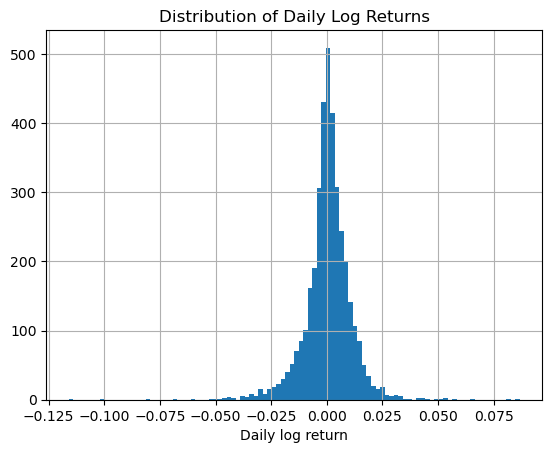

In [78]:
plt.figure()
returns_df["adj_log_return"].hist(bins=100)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Daily log return")
plt.show()

# Stationarity check on returns

In [79]:
adf_result = adfuller(returns_df["adj_log_return"])
pd.Series(
    adf_result[:4],
    index=["ADF Statistic", "p-value", "Lags Used", "Observations"]
)

ADF Statistic   -1.333221e+01
p-value          6.151284e-25
Lags Used        2.600000e+01
Observations     3.746000e+03
dtype: float64

In [80]:
kpss_stat, pval, lags, crit = kpss(returns_df["adj_log_return"], regression="c", nlags="auto")

print("KPSS stat:", kpss_stat)
print("p-value (capped):", pval)
print("lags:", lags)
print("critical values:", crit)

KPSS stat: 0.02353919719220618
p-value (capped): 0.1
lags: 29
critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24044\1079714772.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, pval, lags, crit = kpss(returns_df["adj_log_return"], regression="c", nlags="auto")


ADF rejects unit root

KPSS fails to reject stationarity

Returns treated as stationary

As expected for equity returns, the series is stationary and does not require further transformation.

# ACF and PACF of returns

In [81]:
acorr_ljungbox(
    returns_df["adj_log_return"],
    lags=[10, 20],
    return_df=True
)

,lb_stat,lb_pvalue
10,177.891580,6.417609e-33
20,215.645215,8.817063e-35


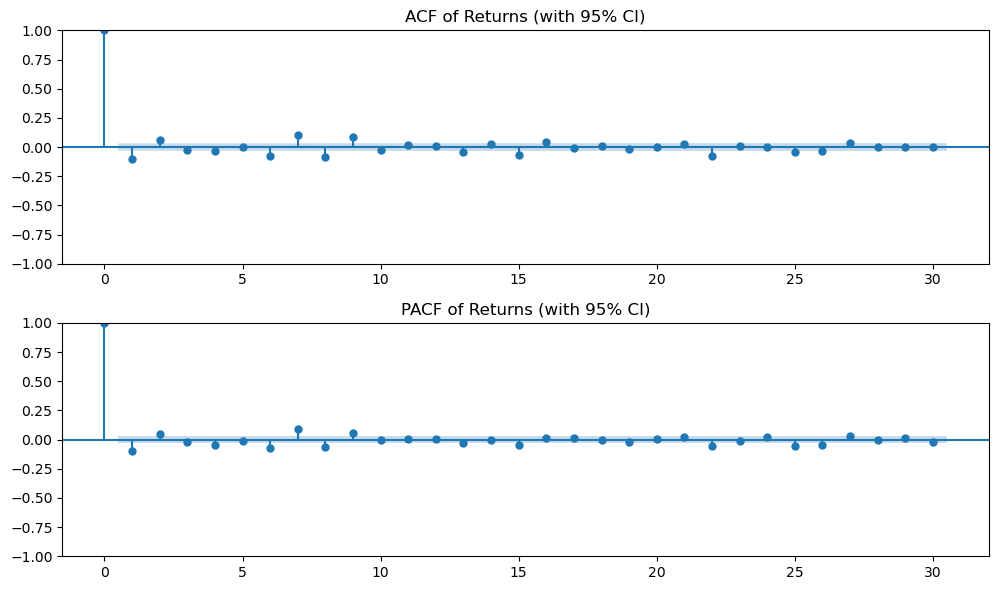

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(returns_df["adj_log_return"], lags=30, ax=ax[0])
ax[0].set_title("ACF of Returns (with 95% CI)")

plot_pacf(returns_df["adj_log_return"], lags=30, ax=ax[1], method="ywm")
ax[1].set_title("PACF of Returns (with 95% CI)")

plt.tight_layout()
plt.show()

Ljung–Box test find significant autocorrelation

Most autocorrelations are very close to zero and any spikes look small and die out quickly

Weak, short-lived autocorrelation

While statistically significant due to sample size, the magnitude of autocorrelations is economically negligible.

# Volatility clustering diagnostics (this is crucial)

In [83]:
# Squared returns
returns_df["squared_returns"] = returns_df["adj_log_return"] ** 2

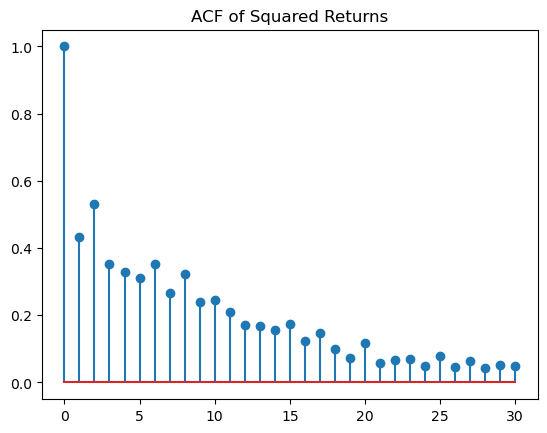

In [84]:
plt.figure()
plt.stem(acf(returns_df["squared_returns"], nlags=30))
plt.title("ACF of Squared Returns")
plt.show()

In [85]:
acorr_ljungbox(
    returns_df["squared_returns"],
    lags=[10, 20],
    return_df=True
)

,lb_stat,lb_pvalue
10,4587.729410,0.0
20,5428.713095,0.0


Significant autocorrelation in squared returns

Evidence of volatility clustering

This justifies modelling conditional variance separately from the mean (GARCH).

# Construct realised volatility

In [86]:
# 21-day rolling realised volatility
returns_df["realised_vol_21d"] = (
    returns_df["adj_log_return"]
    .rolling(window=21) # 21 trading days ~ 1 month
    .std()
)

In [87]:
returns_df_vol = returns_df.dropna()

This realised volatility measure is backward-looking and serves as a noisy proxy for latent volatility.

# Realised volatility behaviour

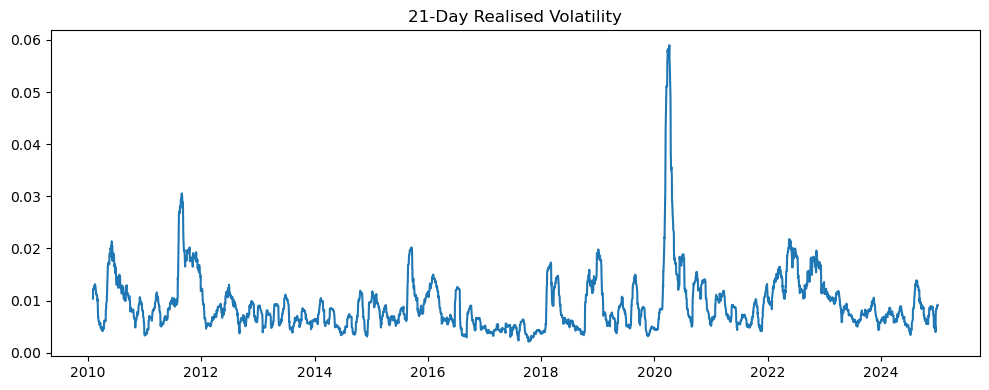

In [91]:
plt.figure(figsize=(10, 4))
plt.plot(returns_df_vol.index, returns_df_vol["realised_vol_21d"])
plt.title("21-Day Realised Volatility")
plt.tight_layout()
plt.show()

# Save transformed datasets

In [89]:
returns_df_vol[["adj_log_return", "realised_vol_21d"]].to_csv(
    "../data/processed/realised_volatility_21d.csv"
)

# Summary

Daily log returns are stationary with weak autocorrelation

Squared returns show significant persistence

Volatility exhibits clustering and smooth dynamics

Separate modelling of mean and variance is appropriate